In [1]:
import sys
import os
import yaml
import numpy as np
import torch
import matplotlib.pyplot as plt
from scipy.stats import norm
# Correct the import statements
try:
    from src.models import GMM, DarcySolver, G1D
    print("Imports from src.models successful.")
except ImportError as e:
    print(f"Error importing from src.models: {e}")

from src.sampling import Sampling
from src.sampling.posterior import *
from src.utils.helpers import *
from src.utils.true_sampling import *
from src.utils.logging_setup import setup_logging

# Load the configuration file from the parent directory
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
config_path = os.path.join(project_root, 'configs', 'config.yaml')
if not os.path.exists(config_path):
    raise FileNotFoundError(f"Configuration file not found: {config_path}")

with open(config_path, 'r') as config_file:
    config = yaml.safe_load(config_file)

Source code directory: /home/rg625/mnt/LatentUQ/src


2025-01-31 19:33:31.334543: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Imports from src.models successful.



# Definitions

In [2]:
# Extract configuration values
data_dir = config['data_dir']
dataset = config['dataset']
batch_size = config['batch_size']
channels = config['channels']
gmm_dim = config['gmm_dim']
n_components = config['gmm_components']
sampler = config['sampler']
likelihood = config['likelihood']
num_steps = config['num_steps']
step_size = config['step_size']
epochs = config['epochs']

In [3]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cuda


In [4]:
# Set the device for computation
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Load the data
y_values_path = f'../{data_dir}/{dataset}_y.npy'
print(f"Loading data from: {y_values_path}")
a_path = f'../{data_dir}/{dataset}_a.npy'

y_values = torch.tensor(np.load(y_values_path)).double().to(device)
a = torch.tensor(np.load(a_path)).double().to(device)
time = torch.linspace(0., 1., 100).to(device)
pushforward = DarcySolver(time)
y_res = (y_values - y_values.mean(dim=0)).squeeze()

data = y_values.view(-1, 1, len(time), channels)
data = data[torch.randperm(data.size(0))]

Using device: cuda
Loading data from: ../data/poisson_y.npy


In [5]:
# Initialize models
GMM_model = GMM(n_components, gmm_dim, width=1., std=1.).to(device)
G_model = G1D(gmm_dim, nu=0.5).to(device)

# Initialize the sampling runner
runner = Sampling(G_model, GMM_model, sampler, likelihood, pushforward, time)
runner.dataset = config['dataset']
runner.log_likelihood_sigma = config['sigma_y']
runner.plot = config['plot']
runner.true_coeffs = a
runner.lrGMM = float(config['lr_GMM'])
runner.lrG = float(config['lr_G'])


In [6]:
### TRAIN ###
n_iter = 20

num_steps_post = 50
step_size_post = 5e-2

# z_after = runner.train(data, n_iter, batch_size, num_steps_post, step_size_post)

In [7]:
### AFTER TRAIN ###
num_gen_samples = 5000
priors_gen, post_gen = runner.generate_samples(data, num_gen_samples, n_iter, num_steps_post, step_size_post, '1')
print(runner.G.nu)
y_prior = runner.pushforward(priors_gen.clone().detach().to(device))
y_prior += runner.log_likelihood_sigma*torch.randn_like(y_prior).to(device)
y_prior = y_prior.detach().cpu().numpy()
y_post = runner.pushforward(post_gen.clone().detach().to(device))
y_post += runner.log_likelihood_sigma*torch.randn_like(y_post).to(device)
y_post = y_post.detach().cpu().numpy()

data_real = y_values.cpu().numpy()

tensor(0.5000)


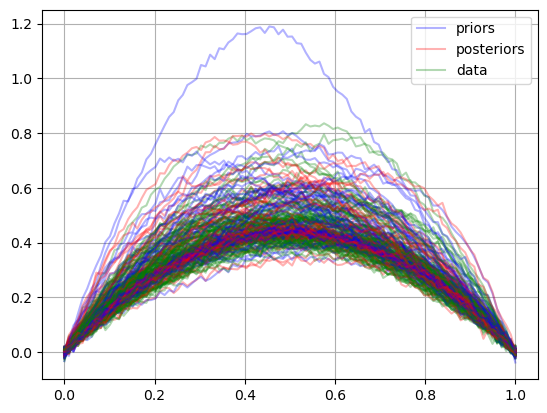

In [8]:
plt.style.use('default')
fig = plt.gcf()

plt.plot(time.cpu().numpy(), y_prior[0, :], alpha=0.3, c='b', label='priors')
plt.plot(time.cpu().numpy(), y_post[0, :], alpha=0.3, c='r', label='posteriors')
plt.plot(time.cpu().numpy(), data_real[0, :], alpha=0.3, c='g', label='data')

for i in range(1, 100):
    plt.plot(time.cpu().numpy(), y_prior[i, :], alpha=0.3, c='b')
    plt.plot(time.cpu().numpy(), y_post[i, :], alpha=0.3, c='r')
    plt.plot(time.cpu().numpy(), data_real[i, :], alpha=0.3, c='g')

# Display legend only once
plt.legend()
plt.grid()
plt.show()
fig.savefig(f'../{runner.dataset}/{runner.sampler}_{runner.likelihood}/{num_steps_post}_{step_size_post}_lrGMM_{runner.lrGMM}_lrG_{runner.lrG}/samples/ode_{runner.dataset}.png')
plt.close()

baseline with itself: 1.8623282855956091
post emd: 2.961901815833798
earthmover distance: 2.877973964831451



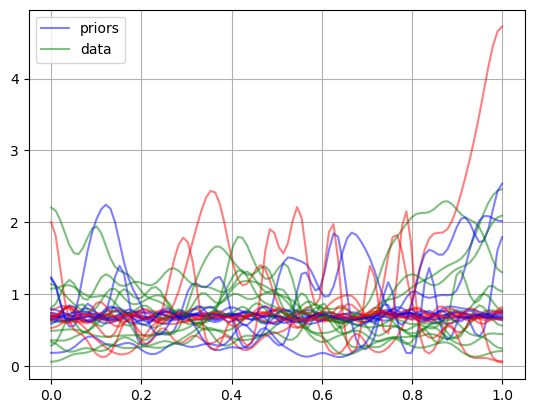

In [9]:
_emd = emd(priors_gen, a)
batch_size = 5000
priors_2 = (runner.G(runner.GMM(batch_size)[0], time).cpu().detach())
log_sigma_true = torch.log(torch.tensor(2)) + 0.2*torch.randn((batch_size, 1), device=device)
ell_true = F.relu(1 + 0.4*torch.randn((batch_size, 1), device=device))
true_noise_1 = sample_true_function(time, batch_size, log_sigma_true, ell_true, nu=torch.tensor(0.5)).detach().squeeze()
true_noise_2 = sample_true_function(time, batch_size, log_sigma_true, ell_true, nu=torch.tensor(0.5)).detach().squeeze()

print(f'baseline with itself: {emd(true_noise_1, true_noise_2)}')
print(f'post emd: {emd(post_gen, a)}')

dir_name = f'../{runner.dataset}/{sampler}_{likelihood}/{num_steps_post}_{step_size_post}_lrGMM_{runner.lrGMM}_lrG_{runner.lrG}/data'
with open(f'{dir_name}/wasserstein_distance.txt', "w") as f:
    f.write(f'earthmover distance: {_emd}\n')
    print(f'earthmover distance: {_emd}\n')

fig = plt.gcf()

plt.plot(time.cpu().numpy(), (priors_gen[0, :]).cpu().numpy(), alpha=0.5, c='b', label='priors')
plt.plot(time.cpu().numpy(), (post_gen[0, :]).cpu().numpy(), alpha=0.5, c='r')
plt.plot(time.cpu().numpy(), a[0, :].cpu().numpy(), alpha=0.5, c='g', label='data')

for i in range(1, 10):
    plt.plot(time.cpu().numpy(), (priors_gen[i, :]).cpu().numpy(), alpha=0.5, c='b')
    plt.plot(time.cpu().numpy(), (post_gen[i, :]).cpu().numpy(), alpha=0.5, c='r')
    plt.plot(time.cpu().numpy(), a[i, :].cpu().numpy(), alpha=0.5, c='g')

# Display legend only once
plt.legend()
plt.grid()
plt.show()
fig.savefig(f'../{runner.dataset}/{runner.sampler}_{runner.likelihood}/{num_steps_post}_{step_size_post}_lrGMM_{runner.lrGMM}_lrG_{runner.lrG}/samples/a_ode_{runner.dataset}.png')
plt.close()

prior emd: 2.911567637876309
ell_prior.mean(): 0.145
ell_prior.std(): 0.231
ell_prior.err: 85.540%
sigma_prior.mean(): 0.883
sigma_prior.std(): 0.388
sigma_prior.err: 27.327%


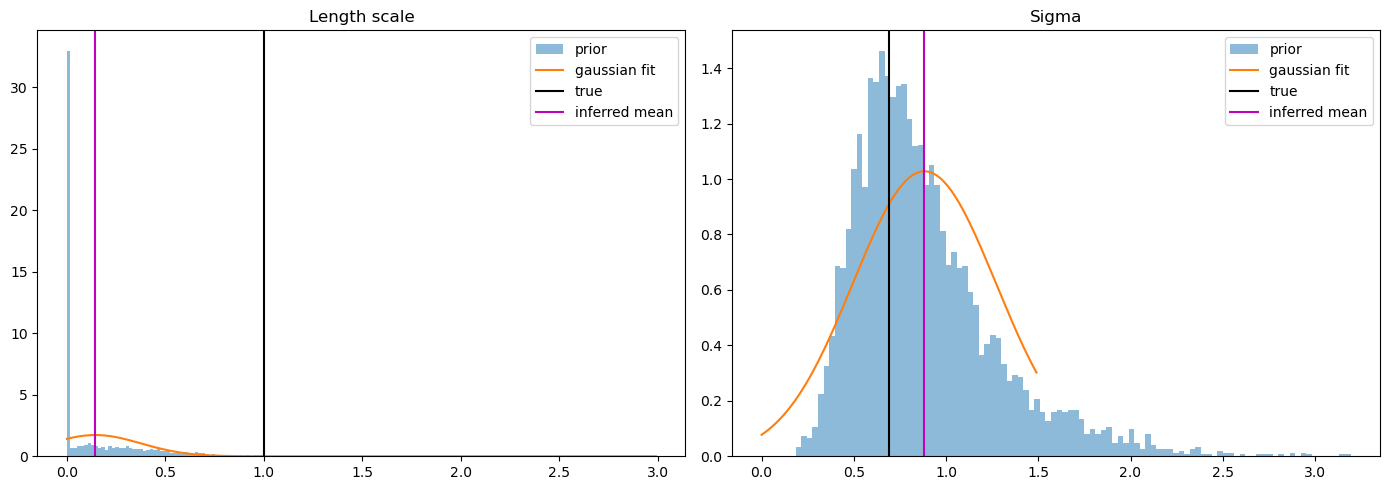

In [10]:
prior_final, means, lower_cholesky, weights = runner.GMM(5000)
# post_final, x_chains, z_chains, grad_logs, acc_rates = runner.langevin(normalized_data[:1000], prior_final, means, lower_cholesky, weights, time, step_size_post, num_steps=num_steps_post)

# priors = runner.G.base_net(prior_final)
sigma = runner.G.log_sigma(prior_final).squeeze(-1) #+ torch.tensor(1e-1, device=device) # [batch_size]
ell = runner.G.length_scale(prior_final).squeeze(-1) #+ torch.tensor(1e-5, device=device)# [batch_size]

mu_ell = ell.mean().detach().cpu().numpy()
std_ell = ell.std().detach().cpu().numpy()
mu_sigma = sigma.mean().detach().cpu().numpy()
std_sigma = sigma.std().detach().cpu().numpy()
# sigma_post = runner.G.log_sigma(post_final).squeeze(-1) #+ torch.tensor(1e-1, device=device) # [batch_size]
# ell_post = runner.G.length_scale(post_final).squeeze(-1) #+ torch.tensor(1e-5, device=device)# [batch_size]
# nu = runner.G.nu(prior_final).squeeze(-1) #+ torch.tensor(0.1, device=device)# [batch_size]
# print(runner.G.sample_function(time, prior_final).shape)
print(f'prior emd: {emd((runner.G.sample_function(time, prior_final, num_samples = 1)).squeeze().detach(), a)}')
# print(f'post emd: {emd(runner.G.sample_function(time, post_final, num_samples = 1).squeeze().detach(), (a - 10*torch.sqrt(time)))}')

print(f'ell_prior.mean(): {mu_ell:.3f}')
print(f'ell_prior.std(): {std_ell:.3f}')
print(f'ell_prior.err: {100*np.abs(mu_ell - 1.)/1.:.3f}%')
# print(f'ell_post.mean(): {ell_post.mean():.3f}')
# print(f'ell_post.err: {100*torch.abs(ell_post.mean() - 0.1)/0.1:.3f}%')
print(f'sigma_prior.mean(): {mu_sigma:.3f}')
print(f'sigma_prior.std(): {std_sigma:.3f}')
print(f'sigma_prior.err: {100*np.abs(mu_sigma - np.log(2))/np.log(2):.3f}%')
# print(f'sigma_post.mean(): {sigma_post.mean():.3f}')
# print(f'sigma_post.err: {100*torch.abs(sigma_post.mean() - torch.log(torch.tensor(2)))/torch.log(torch.tensor(2)):.3f}%')
# Plot the source term and the solution for the first realization
plt.figure(figsize=(14, 5))

# Plot source term f(x)
nu = 1
plt.subplot(1, 2, 1)
plt.hist(ell.cpu().detach().numpy(), bins=100, density=True, alpha = 0.5, label='prior')
x_axis = np.arange(0., 3., 0.01)
plt.plot(x_axis, norm.pdf(x_axis, mu_ell, std_ell), label='gaussian fit')
# plt.hist(ell_post.cpu().detach().numpy(), bins=100, density=True, alpha = 0.5, label='post')
plt.axvline(x = 1., color = 'k', label = 'true')
plt.axvline(x = mu_ell, color = 'm', label = 'inferred mean')
plt.title('Length scale')
plt.legend()

# Plot solution u(x)
plt.subplot(1, 2, 2)
plt.hist(sigma.cpu().detach().numpy(), bins=100, density=True,  alpha = 0.5, label='prior')
x_axis = np.arange(0., 1.5, 0.01)
plt.plot(x_axis, norm.pdf(x_axis, mu_sigma, std_sigma), label='gaussian fit')
# plt.hist(sigma_post.cpu().detach().numpy(), bins=100, density=True,  alpha = 0.5, label='post')
plt.axvline(x = np.log(2), color = 'k', label = 'true')
plt.axvline(x = mu_sigma, color = 'm', label = 'inferred mean')
plt.title('Sigma')
plt.legend()

plt.tight_layout()
plt.show()

torch.Size([10, 100])


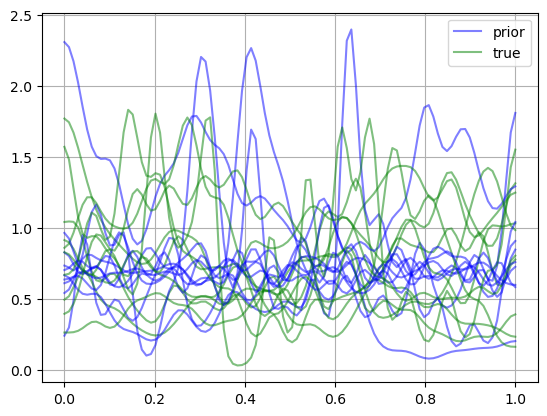

In [11]:
N_marginal = 10

true_noise = []
post_noise = []
prior_noise = (runner.G.sample_function(time, prior_final[:N_marginal], num_samples=1)).detach().squeeze()
true_noise = true_noise_1[:N_marginal]
print(true_noise.shape)
plt.plot(time.cpu().numpy(), prior_noise[0, :].cpu().numpy(), alpha=0.5, c='b', label='prior')
# plt.plot(time.cpu().numpy(), post_noise[0, :].cpu().numpy(), alpha=0.5, c='r', label='post')
plt.plot(time.cpu().numpy(), true_noise[0, :].cpu().numpy(), alpha=0.5, c='g', label='true')

for i in range(1, N_marginal):
    plt.plot(time.cpu().numpy(), prior_noise[i, :].cpu().numpy(), alpha=0.5, c='b')
    # plt.plot(time.cpu().numpy(), post_noise[i, :].cpu().numpy(), alpha=0.5, c='r')
    plt.plot(time.cpu().numpy(), true_noise[i, :].cpu().numpy(), alpha=0.5, c='g')
# Display legend only once
plt.legend()
plt.grid()
plt.show()
plt.close()

In [12]:
# N_samples = 10
# N_marginal = 10
# random_sample, means, lower_cholesky, weights = runner.GMM(N_samples)

# time = torch.linspace(0., 1., 128).to(device)
# # runner.G.nu = torch.tensor(1.5)
# priors_mean = runner.G.mean(random_sample, time).squeeze().detach()
# print(normalized_data[:N_samples].shape)
# posts_mean, x_chains, z_chains, grad_logs, acc_rates = runner.langevin(normalized_data[:N_samples].squeeze(), random_sample, means, lower_cholesky, weights, time, step_size_post, num_steps=num_steps_post)
# posts_mean = runner.G.mean(posts_mean, time).squeeze().detach()

# print(f'mean error: {torch.norm((priors_mean.squeeze() - 10*torch.sqrt(time)), dim = -1).mean()}')
# print(f'mean error post: {torch.norm((posts_mean.squeeze() - 10*torch.sqrt(time)), dim = -1).mean()}')

# plt.plot(time.cpu().numpy(), priors_mean[0, :].cpu().numpy(), alpha=0.3, c='b', label='decoded mean')
# plt.plot(time.cpu().numpy(), posts_mean[0, :].cpu().numpy(), alpha=0.3, c='r', label='decoded post')
# # plt.plot(time.cpu().numpy(), 10*np.sqrt(time.cpu().numpy()), c='g', label='true')
# for i in range(1, N_samples):
#     plt.plot(time.cpu().numpy(), priors_mean[i, :].cpu().numpy(), alpha=0.3, c='b')
#     plt.plot(time.cpu().numpy(), posts_mean[i, :].cpu().numpy(), alpha=0.3, c='r')

# # Display legend only once
# plt.legend()
# plt.grid()
# plt.show()
# plt.close()

In [13]:
# log_sigma = runner.G.log_sigma
# log_sigma_err = (100*torch.abs(log_sigma.detach() - torch.log(torch.tensor(2.)))/torch.log(torch.tensor(2.))).item()
# ell = runner.G.ell
# ell_err = (100*torch.abs(ell.detach() - 0.1)/0.1).item()
# print(log_sigma)
# print(ell)
# print(f'log_sigma_err: {log_sigma_err:.3f}%')
# print(f'ell_err: {ell_err:.3f}%')

In [14]:
print(runner.GMM.means.squeeze())
print(runner.GMM.create_cov().squeeze())
print(runner.GMM.weights)

tensor([[ 0.9642,  0.6716,  0.3419,  1.0095, -1.7004],
        [ 0.2769,  1.7622,  0.4797,  2.0780,  0.5469]], device='cuda:0',
       grad_fn=<SqueezeBackward0>)
tensor([[[ 0.4083,  0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.7458,  0.5669,  0.0000,  0.0000,  0.0000],
         [ 0.3805, -0.0036,  1.0217,  0.0000,  0.0000],
         [-0.4976,  0.8960, -0.0738,  0.6965,  0.0000],
         [ 0.3558,  2.5277,  0.8716,  0.3233,  1.0918]],

        [[ 0.2433,  0.0000,  0.0000,  0.0000,  0.0000],
         [-1.1568,  1.2450,  0.0000,  0.0000,  0.0000],
         [-0.7944,  0.2115,  0.8168,  0.0000,  0.0000],
         [ 1.9242,  0.2737,  1.1373,  0.1394,  0.0000],
         [ 2.4422,  0.5071, -0.0572, -0.5299,  0.5188]]], device='cuda:0',
       grad_fn=<SqueezeBackward0>)
tensor([0.5246, 0.4754], device='cuda:0', grad_fn=<SoftmaxBackward0>)


In [15]:
dir_name = f'../{runner.dataset}/{runner.sampler}_{runner.likelihood}/{num_steps_post}_{step_size_post}_lrGMM_{runner.lrGMM}_lrG_{runner.lrG}/chains'
N = 100
prior_final, means, lower_cholesky, weights  = runner.GMM(N)
print(prior_final.shape)
# samples_post = torch.randn(*prior_final.size(), device = runner.device)
post_final, x_chains, z_chains, grad_logs, acc_rates = langevin(data[:N].squeeze(), 
                                                                prior_final, 
                                                                means, 
                                                                lower_cholesky, 
                                                                weights, 
                                                                time, 
                                                                step_size_post, 
                                                                num_steps_post,
                                                                runner.G,
                                                                pushforward,
                                                                runner.log_likelihood_sigma,
                                                                plot=True,
                                                                sampler='ula')

print(f'x_chains.shape: {x_chains.shape}')
x_chain_post = x_chains

print(f'z_chains.shape: {z_chains.shape}')
z_chain_post = z_chains

print(f'acc_rates.shape: {acc_rates.shape}')
acc_rates_post = acc_rates

print(f'grad_logs.shape: {grad_logs.shape}')
grad_logs_post = grad_logs

# particles = np.load(f'{dir_name}/particles_chains_best.npy')
# print(f'particles_chains_best.shape: {particles.shape}')

# emd_prior = np.load(f'{dir_name}/emd_prior.npy')
loss_e = np.load(f'{dir_name}/loss_gmm.npy')
loss_g = np.load(f'{dir_name}/loss_g.npy')
# print(f'emd_prior.shape: {emd_prior.shape}')
print(f'loss_e.shape: {loss_e.shape}')
print(f'loss_g.shape: {loss_g.shape}')
plt.style.use('default')

torch.Size([100, 5])
x_chains.shape: (51, 100, 100)
z_chains.shape: (51, 100, 5)
acc_rates.shape: (0,)
grad_logs.shape: (50, 100)
loss_e.shape: (196,)
loss_g.shape: (196,)


124.204


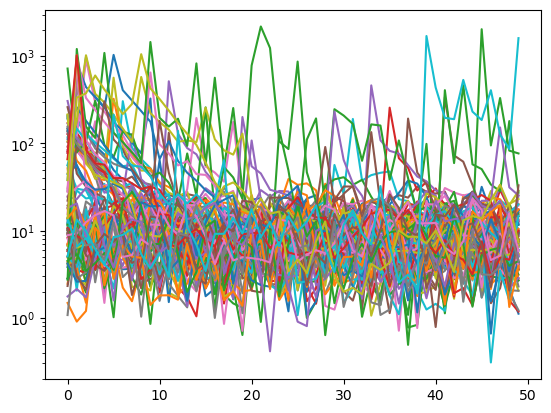

In [16]:
print(f'{grad_logs_post[:, -1].mean():.3f}')
plt.semilogy(grad_logs_post[:])
plt.show()

0.6801285832967472
(51, 100, 5)


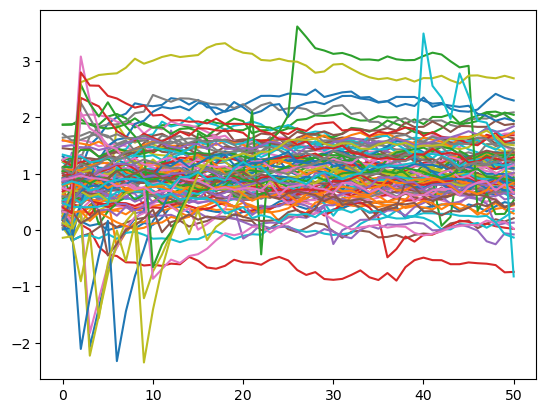

In [17]:
# plt.plot(z_chain_post[:, :, 0, 0])
print(z_chain_post[0, :, 0].mean())
print(z_chain_post.shape)
plt.plot(z_chain_post[:, :, 0])
plt.show()

(51, 100, 100)


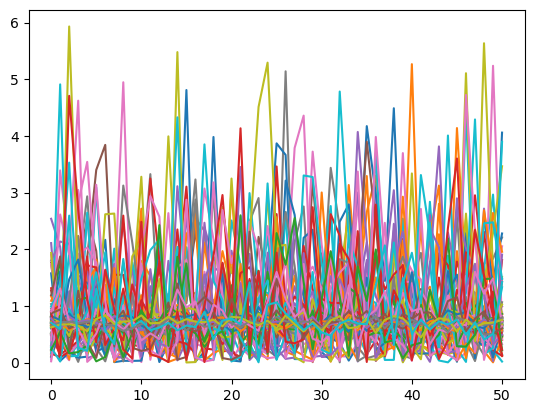

In [18]:
print(x_chain_post.shape)
plt.plot(x_chain_post[:, :, 0])
plt.show()

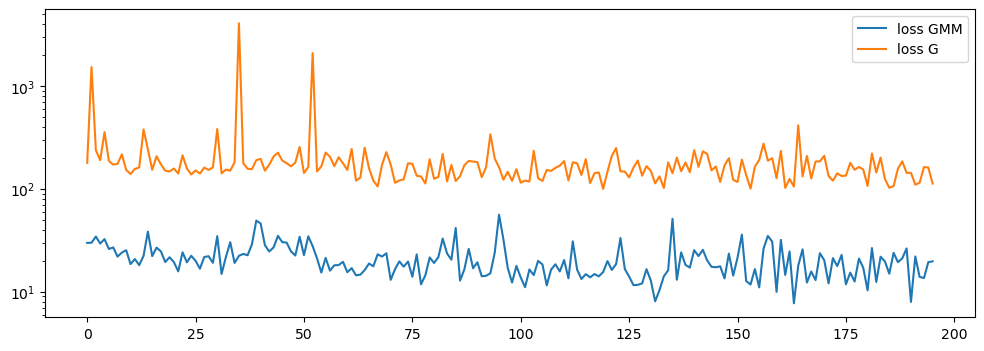

In [19]:
fig, ax = plt.subplots(figsize=(12, 4))  # Adjust the figsize parameter to make the figure longer on the x-axis and shorter on the y-axis
ax.semilogy(loss_e[:], label = 'loss GMM')
ax.semilogy(loss_g[:], label = 'loss G')
ax.legend()
fig.show()

In [20]:
# fig, ax = plt.subplots(figsize=(12, 4))  # Adjust the figsize parameter to make the figure longer on the x-axis and shorter on the y-axis
# print(min(emd_prior))
# print(np.where(emd_prior == min(emd_prior)))
# ax.semilogy(emd_prior[:], label='EMD')
# ax.legend()
# fig.show()
# output_file = f'../{runner.dataset}/{runner.sampler}_{runner.likelihood}/{num_steps_post}_{step_size_post}_lrGMM_{runner.lrGMM}_lrG_{runner.lrG}/samples/emd_{runner.dataset}.png'
# fig.savefig(output_file, dpi=300, bbox_inches='tight')